### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Apr 3rd at 11.59pm CST
---


This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [1]:
# Kludge to fix the bug with draw_ellipse in astroML v1.0
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, sigmas=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 
                   + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for sigma in sigmas:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                        2 * sigma *  sigma1, 2 * sigma *  sigma2,
                        alpha * 180. / np.pi,
                        **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform those cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [2]:
# BS - import the things
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format='retina'

# BS - load the data
data = np.load('/Users/smithwj/Box Sync/Astrostatistics/astr_8070_s21/coursework/homeworks/hw_data/hw6_data_1.npy')

# BS - split the data into features and targets
X = data[:,0:2]
y = data[:,2]


#### Part 1

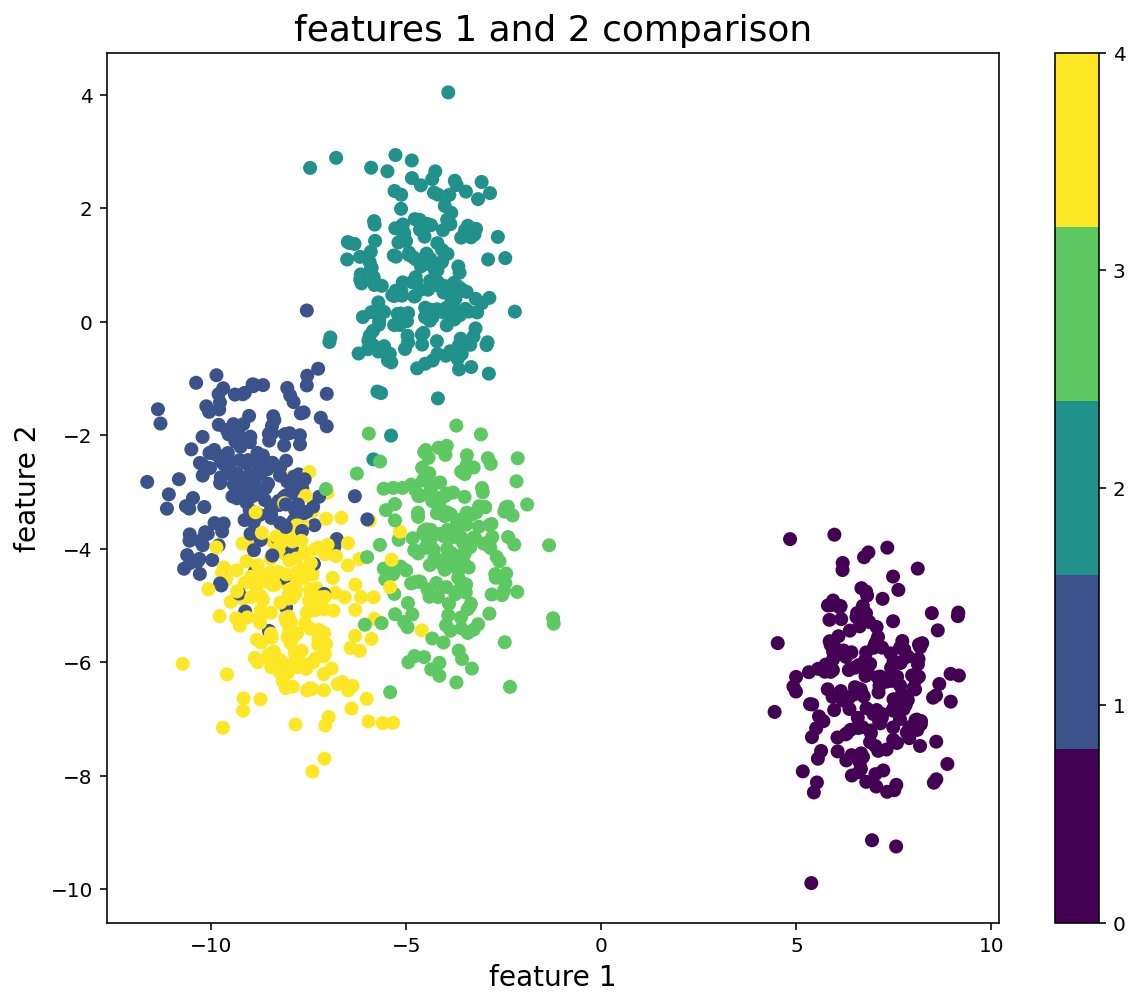

In [3]:
# BS - this is me trying to play around with formatting the color bar from the 
# example in the lecture. I got the coloring to work, but the number labels are
# still a little off...
##### can probably use iris example to format colorbar
#formatter = plt.FuncFormatter(lambda i, *args: data[int(i),2])

# BS - plot the data

plt.figure(figsize=(10, 8))
plt.scatter(data[:,0], data[:,1], c=data[:,2], cmap=plt.cm.get_cmap('viridis', 5))
plt.xlabel("feature 1", fontsize=14)
plt.ylabel("feature 2", fontsize=14)
plt.title("features 1 and 2 comparison", fontsize=18)
plt.colorbar(ticks=[0, 1, 2, 3, 4])
plt.show()


#### Part 2

The optimal bandwidth is 0.472


<ipython-input-4-21d939b75efb>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T


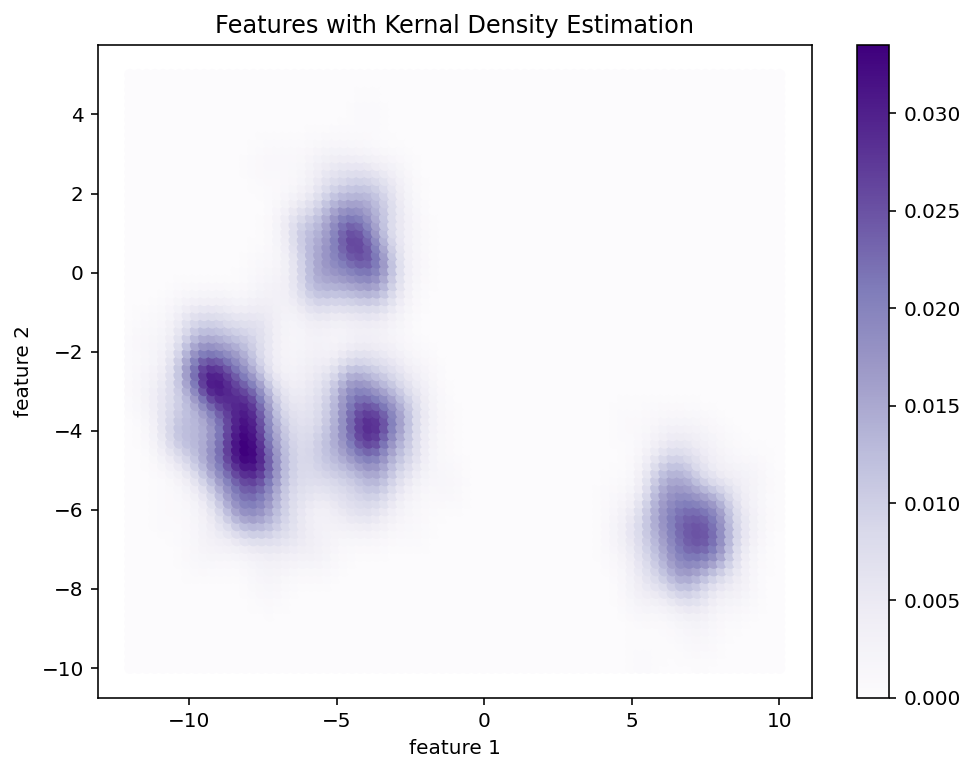

In [4]:
#### kernal density estimation
# BS - import the needed packages from sklearn

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV


# BS -  Test 30 bandwidths from 0.1 to 1.0
bwrange = np.linspace(0.1, 1, 30) 

# BS - Do 5-fold cross validation
K = 5 

# BS - search over the bandwidths for the optimal one
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K)

# BS - fit the data 
grid.fit(X) 

# BS - get the optimal bandwidth
h_opt = grid.best_params_['bandwidth']
print("The optimal bandwidth is {:.3}".format(h_opt))

# BS - apply the kernal density estimation to the data using the optimal
# bandwidth and gaussian kernal and fit to the feature data
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(X)

# BS - make a grid in parameter space
u = np.linspace(-12, 10, 80)
v = np.linspace(-10, 5, 80)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T

# BS - evaluate the model on the grid
dens = np.exp(kde.score_samples(Xgrid)) 


# BS - plot the model
plt.figure(figsize=(8, 6))
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()
plt.title("Features with Kernal Density Estimation")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()


#### Part 3

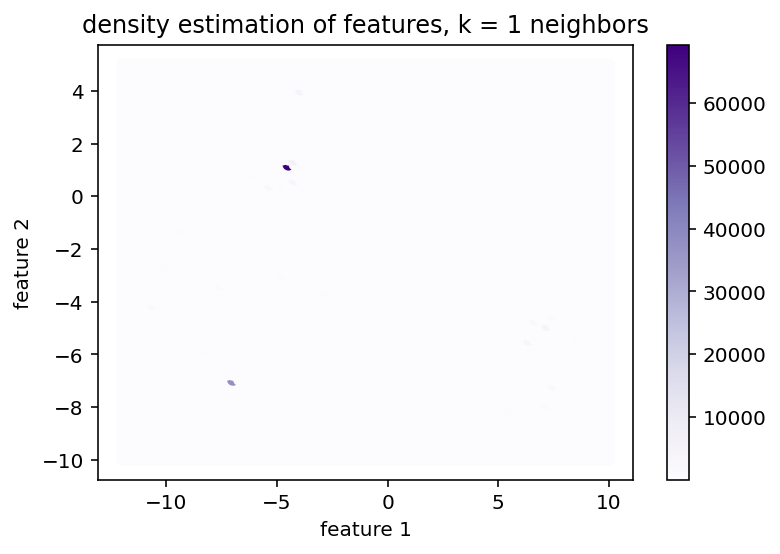

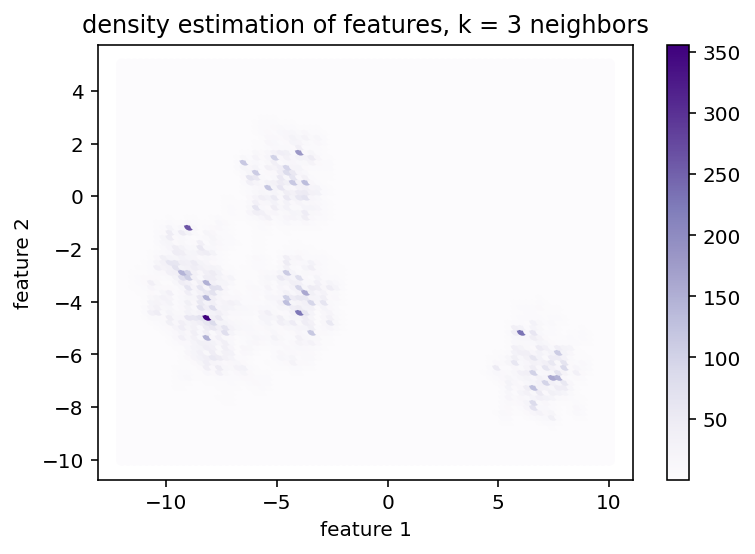

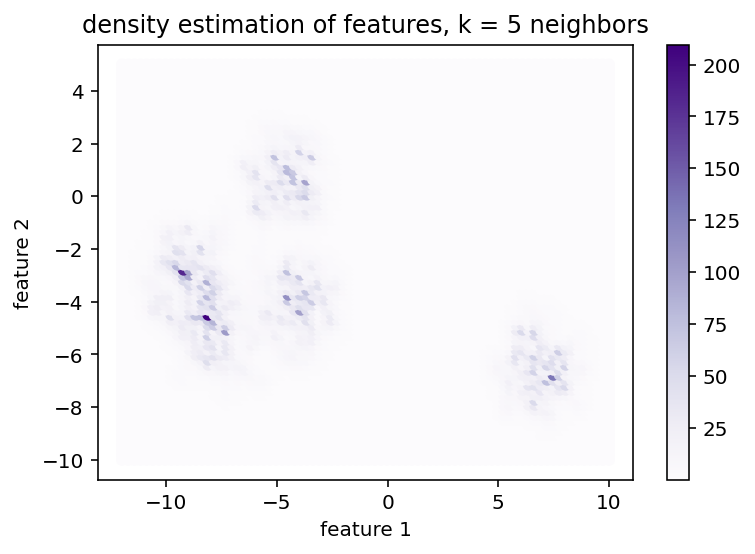

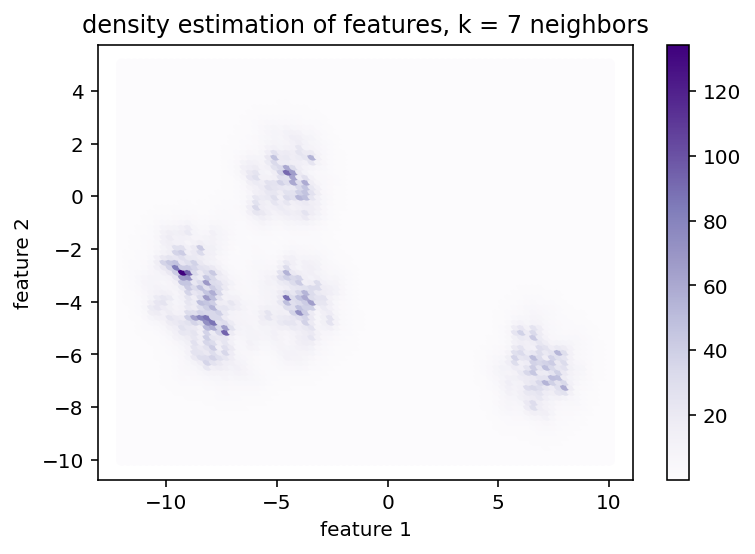

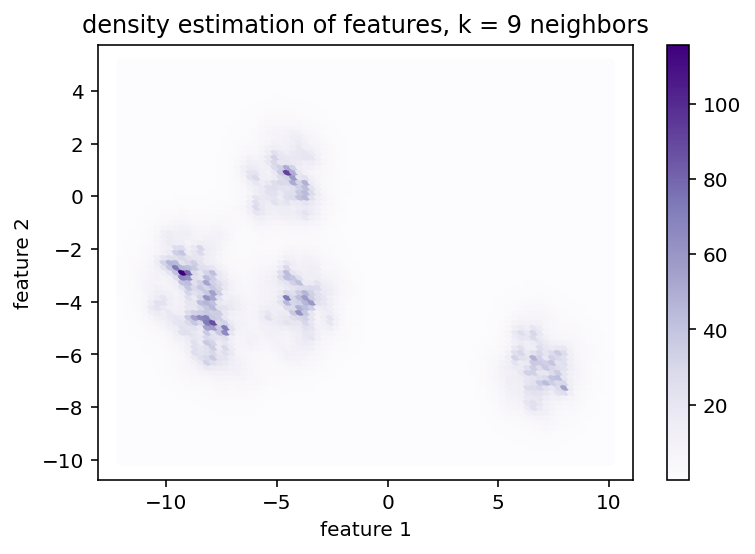

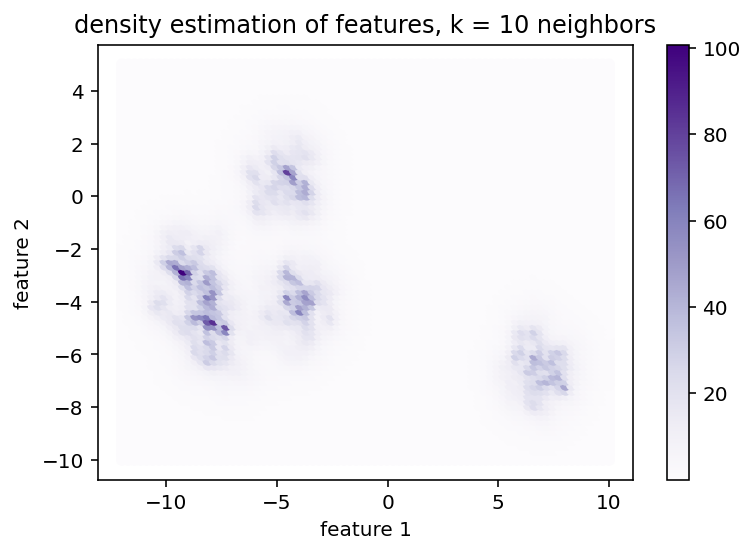

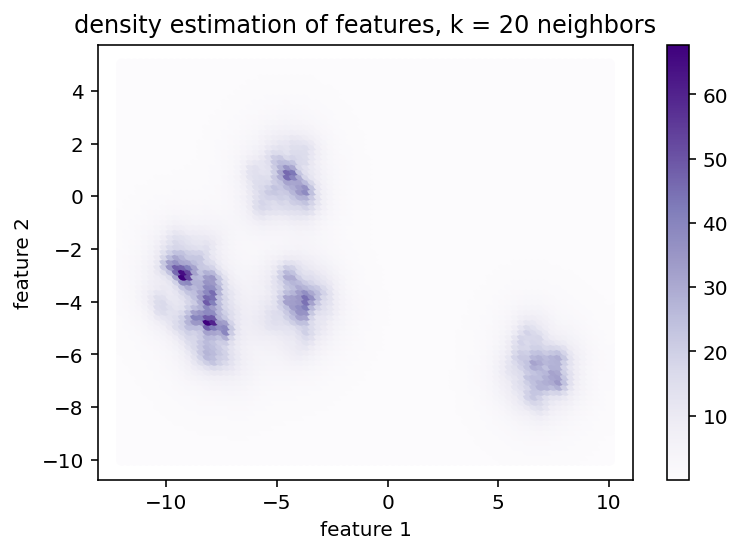

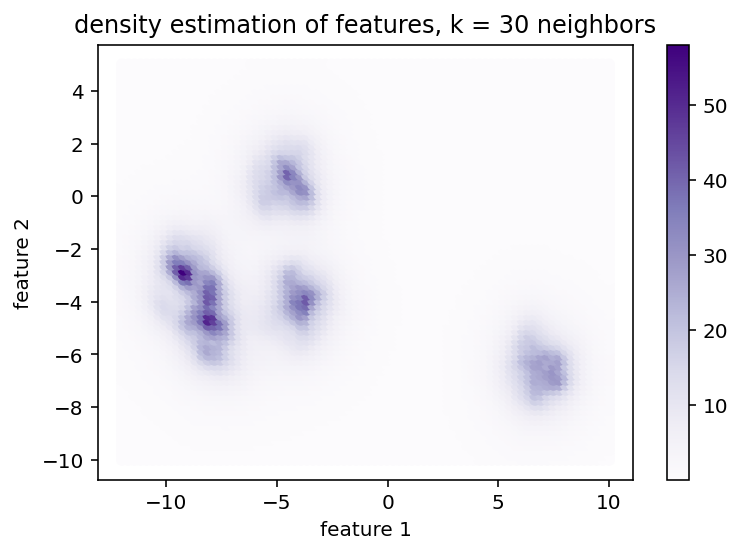

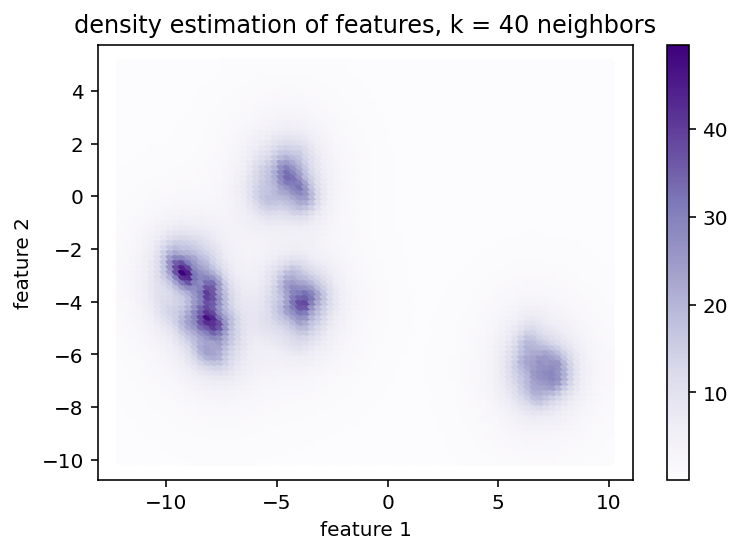

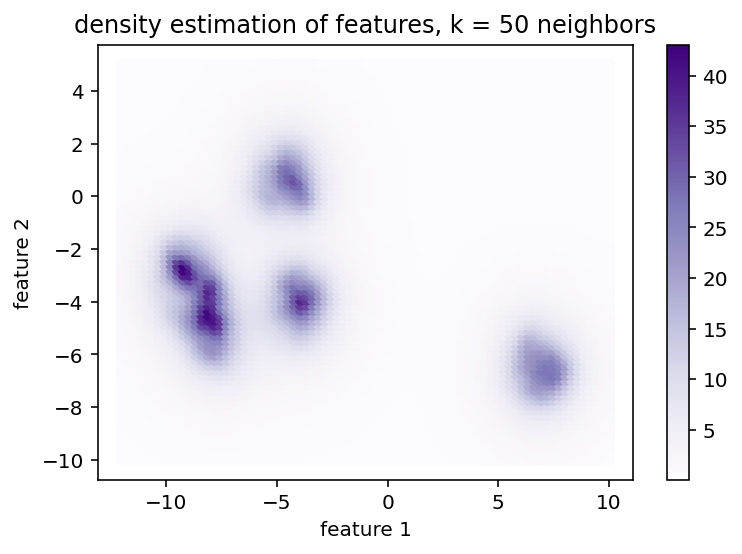

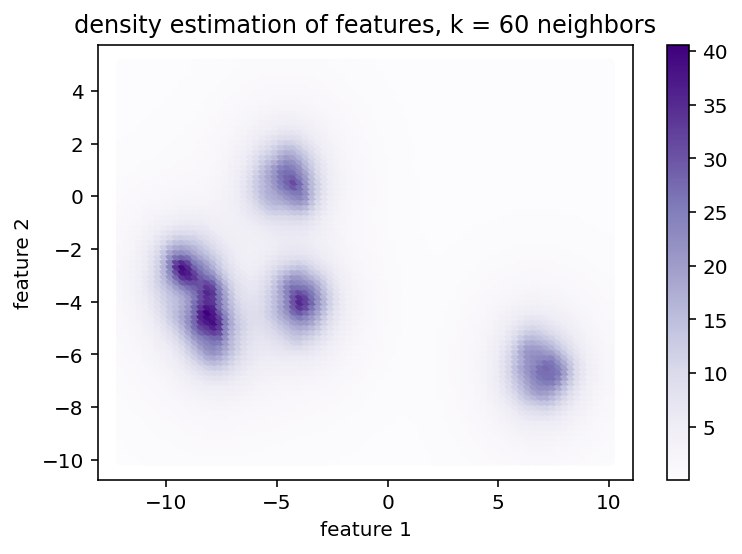

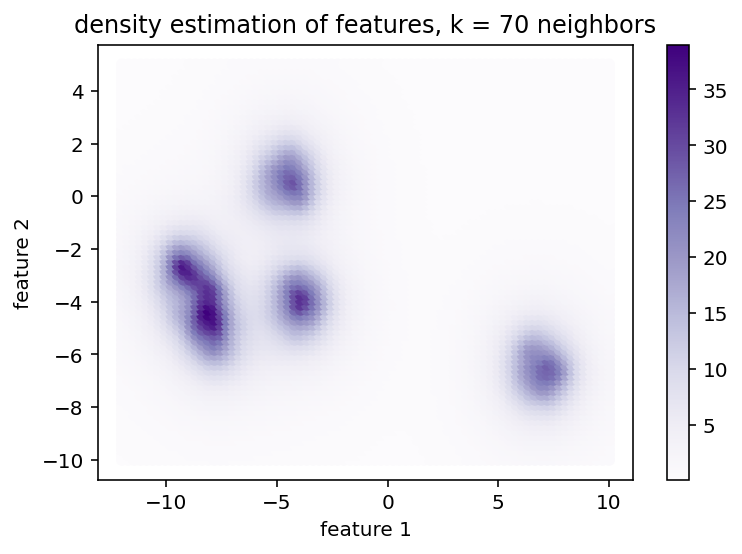

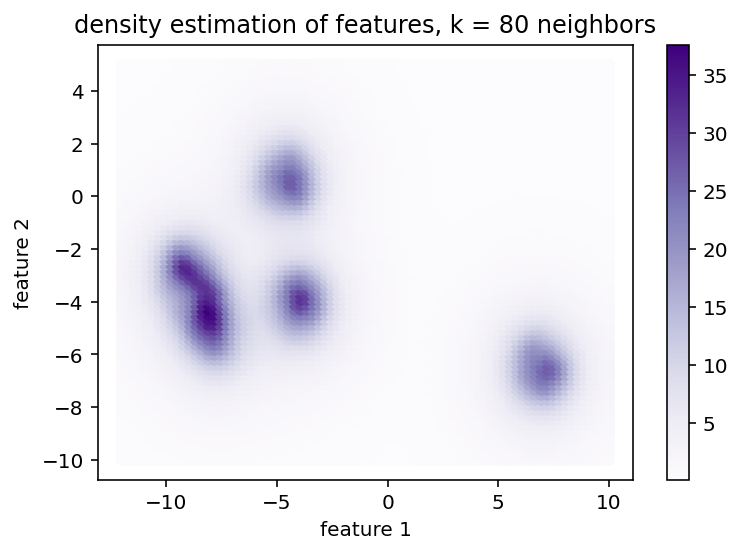

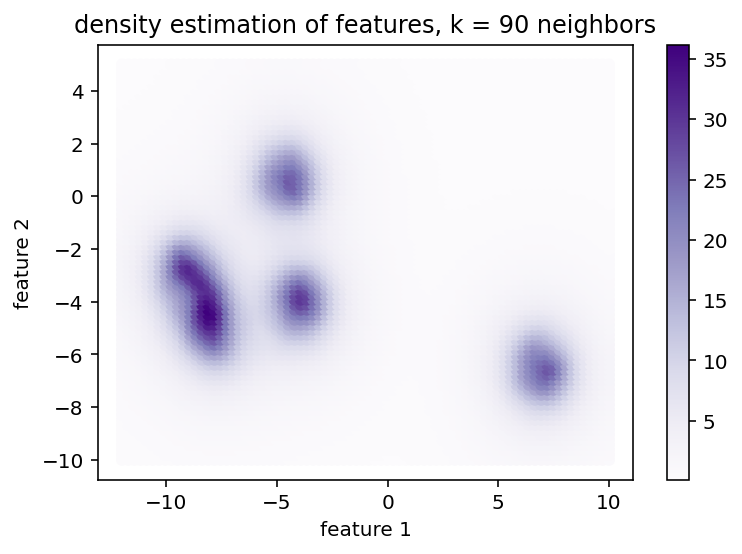

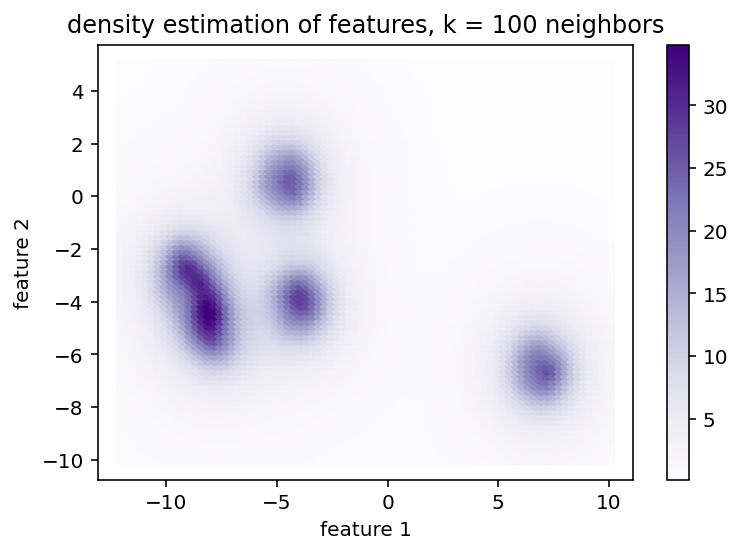

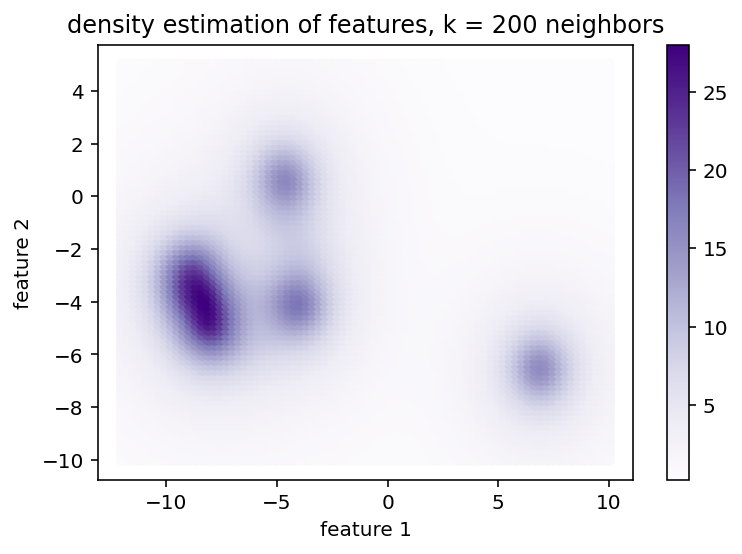

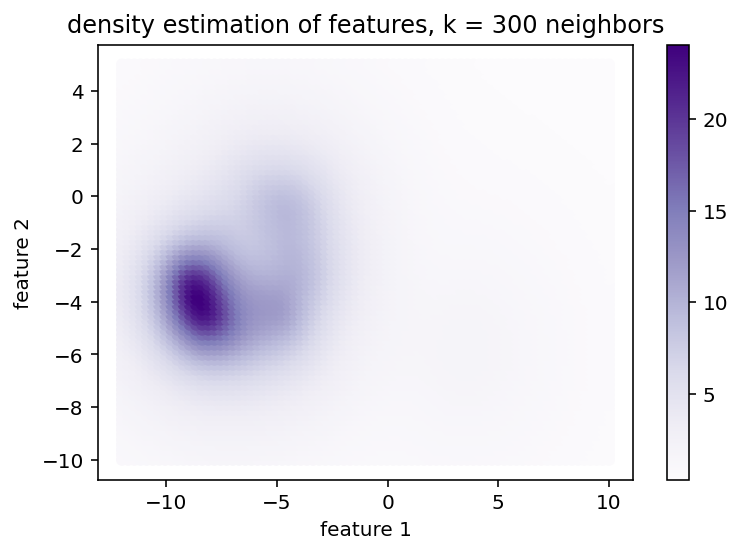

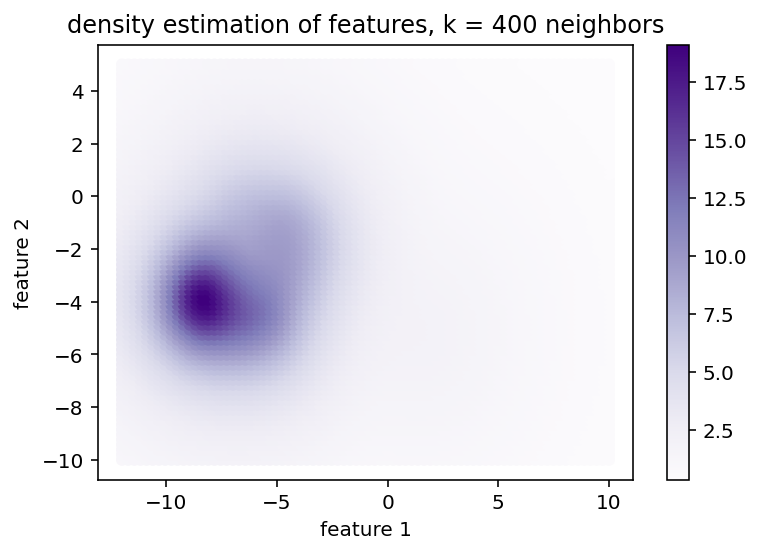

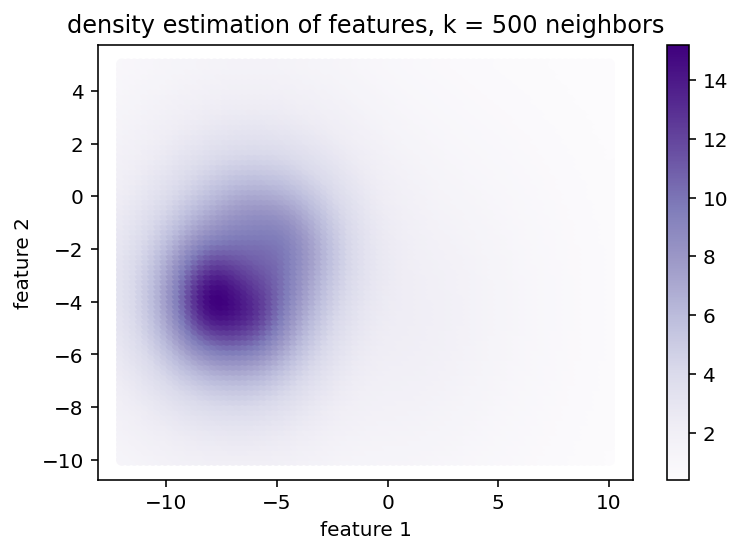

In [5]:

# BS - import the needed sklearn package
from astroML.density_estimation import KNeighborsDensity

# BS - create an array of nearest neighbor values to test and loop over
k = np.concatenate([np.arange(1,10,2), np.arange(10, 100, 10), np.arange(100, 600, 100)])

# BS - for each value of of the nearest neighbor, do density estimation
for i in k:

    nbrs = KNeighborsDensity('bayesian', n_neighbors=i)
    nbrs.fit(X)

    dens_nbrs = nbrs.eval(Xgrid)

    plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_nbrs, 
        cmap="Purples", edgecolor="None")

    plt.colorbar()
    plt.title("density estimation of features, k = %i neighbors" %i)
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.show()


It looks like the ideal nearest neighbors is somewhere in the 50 - 70 range to match the plot from the kernel density estimation from above.

#### Part 4

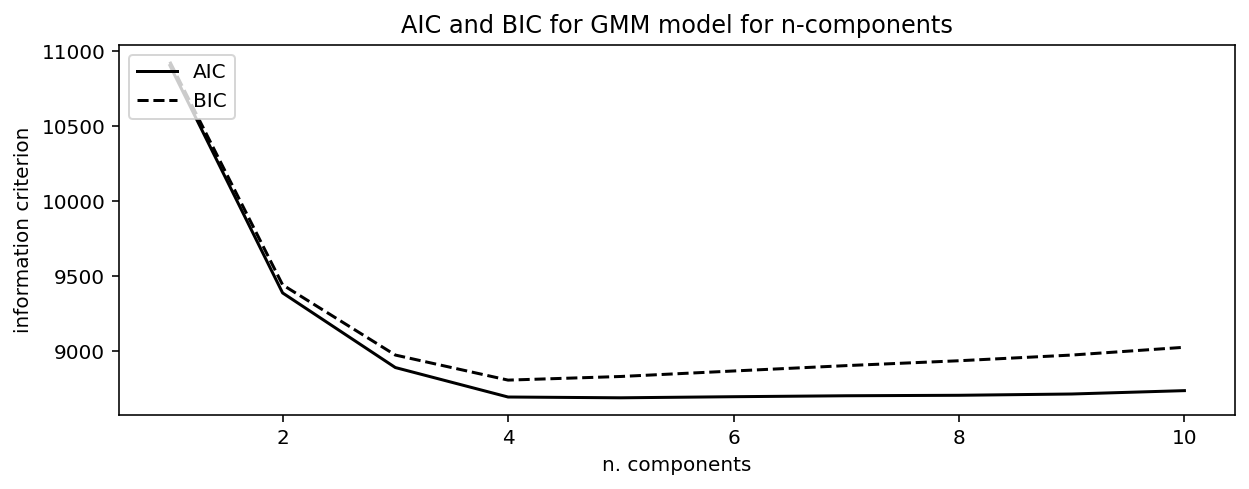

In [6]:
# BS - Gaussian mixture model

# BS - import the package
from sklearn.mixture import GaussianMixture

# BS - create array of number of components
N = np.arange(1, 11)

# BS - fit each model with number of componants
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# BS - compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]


# BS - plot AIC and BIC
fig = plt.figure(figsize=(10, 3.4))
ax = fig.add_subplot()
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_title("AIC and BIC for GMM model for n-components")
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)
plt.show()


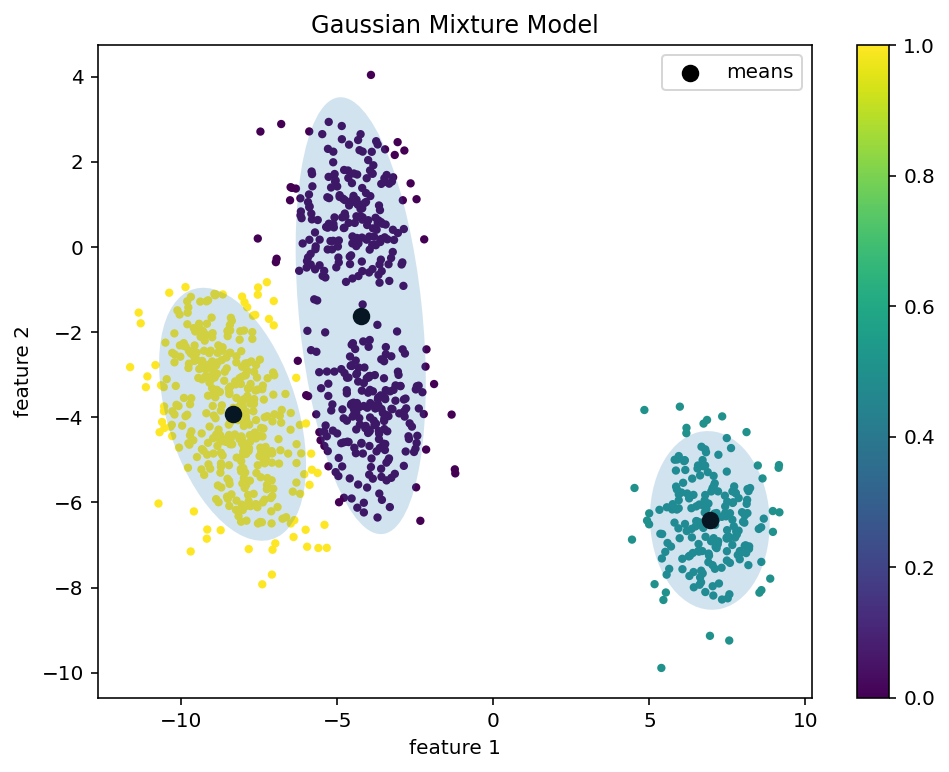

In [7]:
# BS - find the best BIC

M_best = np.argmin(BIC)

# BS - fit the GMM with the number of components that give the best BIC
gmm = GaussianMixture(n_components=M_best).fit(X)
labels = gmm.predict(X)

# BS - plot the GMM prediction and their means
plt.figure(figsize=(8, 6))
plt.title("Gaussian Mixture Model")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap=plt.cm.get_cmap('viridis', 3))
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], c='k', s=60, label="means")
plt.colorbar()
plt.legend()
# BS - note: Still having some colorbar issues

# BS - plot ellipses at 2-sigam (95%)
draw_ellipse(mu = gmm.means_[0], C=gmm.covariances_[0], sigmas=[2], alpha=0.2)
draw_ellipse(mu = gmm.means_[1], C=gmm.covariances_[1], sigmas=[2], alpha=0.2)
draw_ellipse(mu = gmm.means_[2], C=gmm.covariances_[2], sigmas=[2], alpha=0.2)




#### Part 5

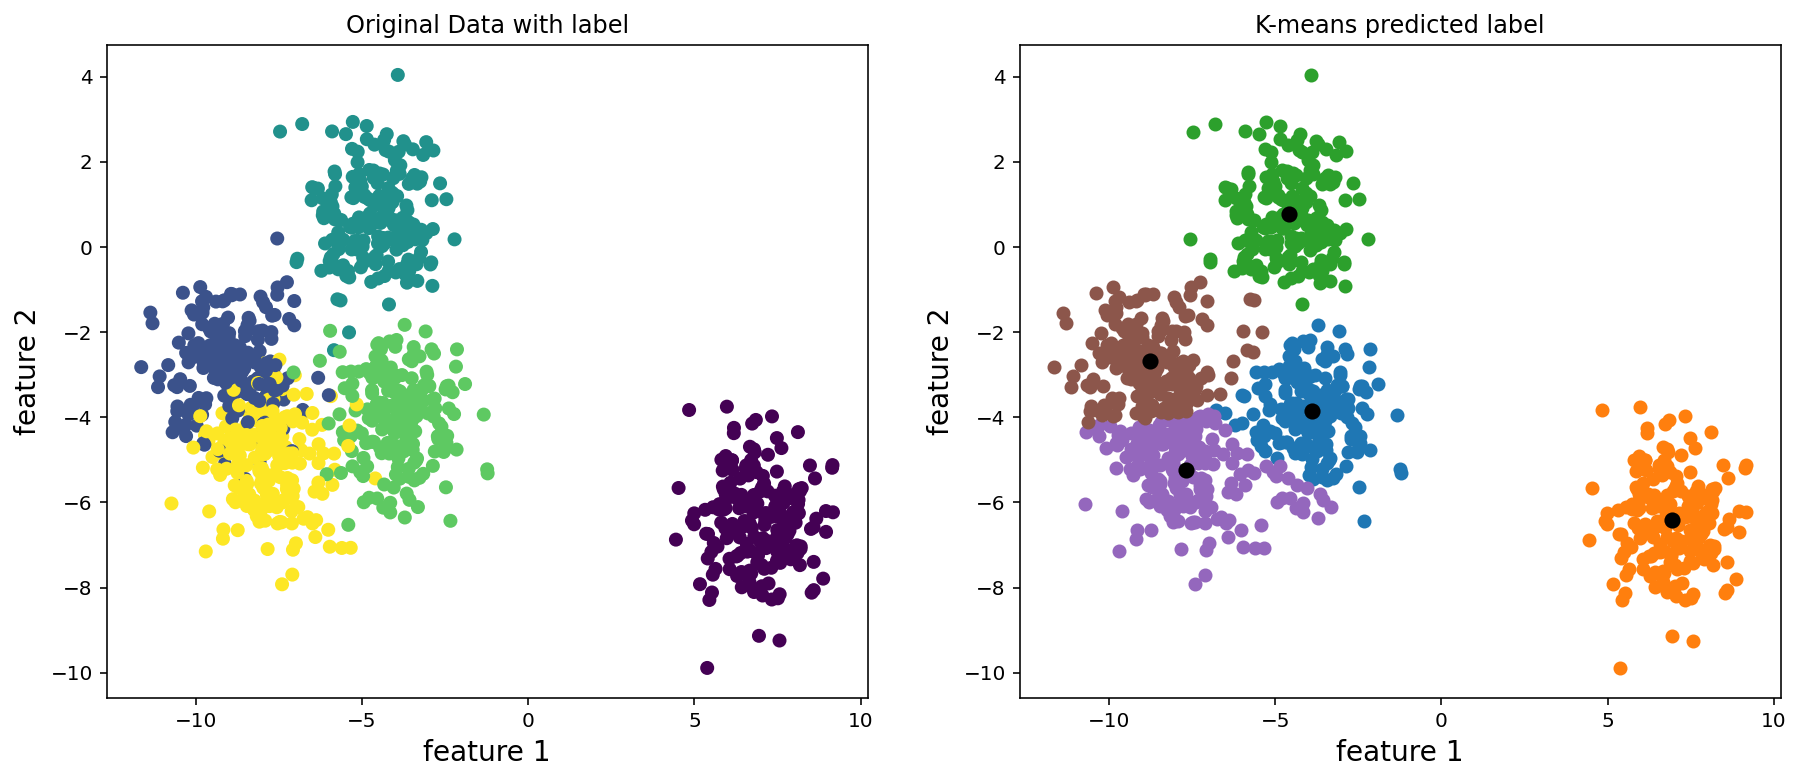

In [8]:
# BS - import the k-means and standardscalar packages

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# BS - fit and scale data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# BS - kmeans on scaled data, fit, find the centers, and predict the labels
clf = KMeans(n_clusters=5) #Try 5 clusters\
clf.fit(X_scaled)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X_scaled)

# BS - find the centers in the unscaled data
centers_inv = scaler.inverse_transform(clf.cluster_centers_)


# BS - plot the original data and k-means
# BS - first up, the original data
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
ax1.scatter(data[:,0], data[:,1], c=data[:,2], cmap=plt.cm.get_cmap('viridis', 5))
ax1.set_title("Original Data with label")
ax1.set_xlabel("feature 1", fontsize=14)
ax1.set_ylabel("feature 2", fontsize=14)

# BS - second, the predicted k-means data with centers
ax2 = fig.add_subplot(122)
colors = ['C0', 'C1', 'C2', 'C4', 'C5']
for ii in range(5):
    ax2.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii], cmap=plt.cm.get_cmap('viridis', 5))
ax2.scatter(centers_inv[:,0], centers_inv[:,1], c='k', s=50)
ax2.set_title("K-means predicted label")
ax2.set_xlabel("feature 1", fontsize=14)
ax2.set_ylabel("feature 2", fontsize=14)
#fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=[0, 1, 2, 3, 4])
plt.show()

# BS - *still* struggling with colorbar issues. 


---

## Problem 2

This problem has to do with dimensional reduction. We're going to load in a sample of SDSS Imaging data. 

1. Execute the cell below to read in the data, print out the feature names, and create a data matrix out of a subset of features.

In [9]:
from astroML.datasets import fetch_imaging_sample
data = fetch_imaging_sample()  

data.shape  # number of objects in dataset

print(data.dtype.names)

keylist = ['ra', 'dec', 'rExtSFD', 'uRaw', 
           'gRaw', 'rRaw', 'iRaw', 'zRaw', 
           'uErr', 'gErr', 'rErr', 'iErr', 
           'zErr', 'uRawPSF', 'gRawPSF', 
           'rRawPSF', 'iRawPSF', 'zRawPSF', 
           'upsfErr', 'gpsfErr', 'rpsfErr', 
           'ipsfErr', 'zpsfErr']

X = np.column_stack([data[key] for key in keylist]) 

('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'uRawPSF', 'gRawPSF', 'rRawPSF', 'iRawPSF', 'zRawPSF', 'upsfErr', 'gpsfErr', 'rpsfErr', 'ipsfErr', 'zpsfErr', 'type', 'ISOLATED')


2. Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to $2$ features. What is the explained variance of the data encapsulated in these eigen-features?


3. Access the `type` key of the `data` structure and make an array of labels out of these. Do some research in astroML documentation to find out what these integer types correspond to, and state that here.


4. Choose $5000$ random integers between 0 and the number of samples in the data matrix. Record these integers because you'll use them later. Make a scatter plot of the PCA-reduced data for these $5000$ random samples, colored by their corresponding `type`. *(You may want to set the transparency to be lower than 1 to see the mixing of samples.)*


5. Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only on the $5000$ random samples identified in the previous part. 
    - Try `LocallyLinearEmbedding`, `Isomap`, and `TSNE` algorithms, setting the number of components to be $2$ in all cases. 
    - As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their `type`. For LLE and Isomap, experiment with the number of nearest neighbors between $5$ and $100$ to see what visually gives the best separation in `type` populations. For TSNE, do the same for the perplexity attribute. 
    - Which algorithm gives the cleanest way to visually see the two populations of sources? *(This will be subjective according to the samples you trained on, and even the randomness of the algorithms.)*

### Solution

#### Part 2

In [10]:
# BS - import the PCA package

from sklearn.decomposition import PCA

# BS - initiate and fit the data

pca = PCA(n_components=2, svd_solver='randomized')
pca.fit(X) 

# BS - print the explained variance from the two features
evals = pca.explained_variance_ratio_ 
print('Expained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))

Expained fractional variance of data encapsulated in the eigenvalues: [0.53320897 0.25010565]


#### Part 3

In [11]:
type_data = data['type']

# BS - documtation for the data is here
# https://www.astroml.org/modules/generated/astroML.datasets.fetch_imaging_sample.html

# Note - AstroML site is down...so that link above is not working
# Note 2 - William was the first person in the class to respond to my request for info
# about these data types since the AstroML site is down. He pointed me in the 
# direction of the SDSS schema browser:
# http://cas.sdss.org/dr7/en/help/browser/browser.asp
# so each of these labels represents an object photo type in SDSS!


#### Part 4

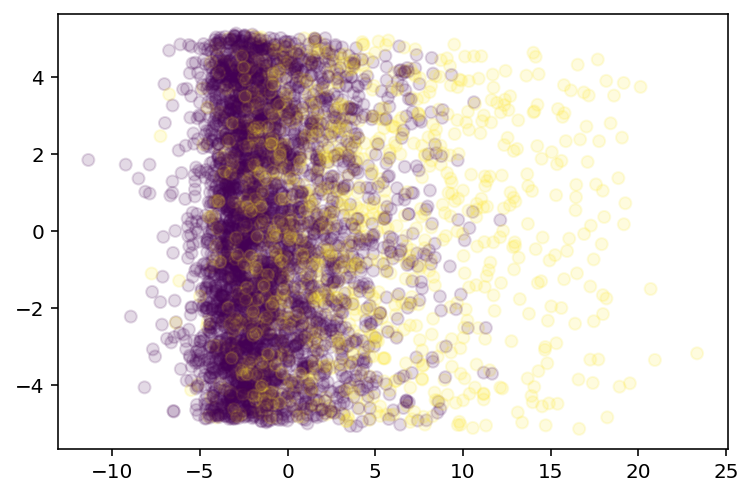

In [12]:
# BS - create 5000 random integers between 0 and the length of our data

from numpy import random

random.seed(0)
random_ints = np.random.randint(0, len(X), 5000)

# BS - cull the X data and y data to just the randoms chosen

X_rand = X[random_ints,:]
y_rand = type_data[random_ints]

# BS - fit the culled data with pca
pca.fit(X_rand)

# BS - transform and plot the data
X_rand_reduced = pca.transform(X_rand)

# BS - plot the transformed data
plt.scatter(X_rand_reduced[:, 0], X_rand_reduced[:, 1], 
            c=y_rand, cmap='viridis', alpha=0.15)
plt.show()


#### Part 5

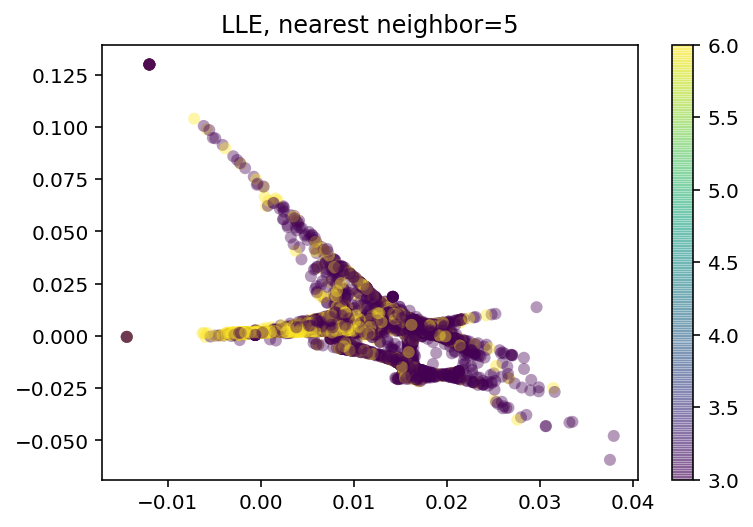

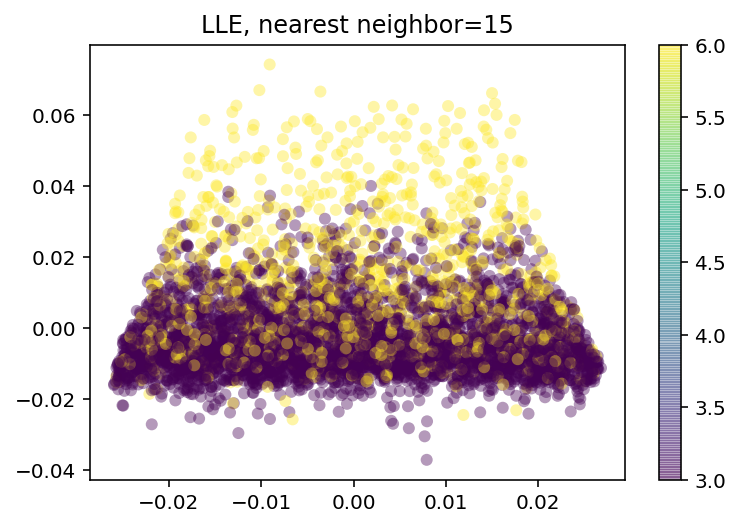

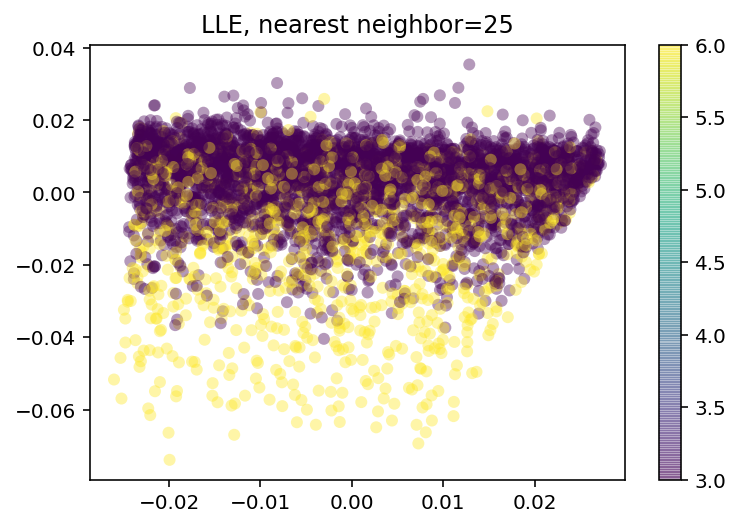

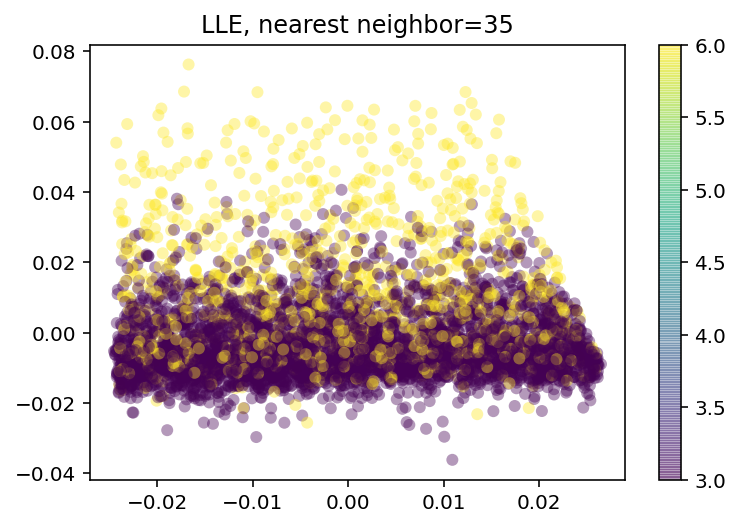

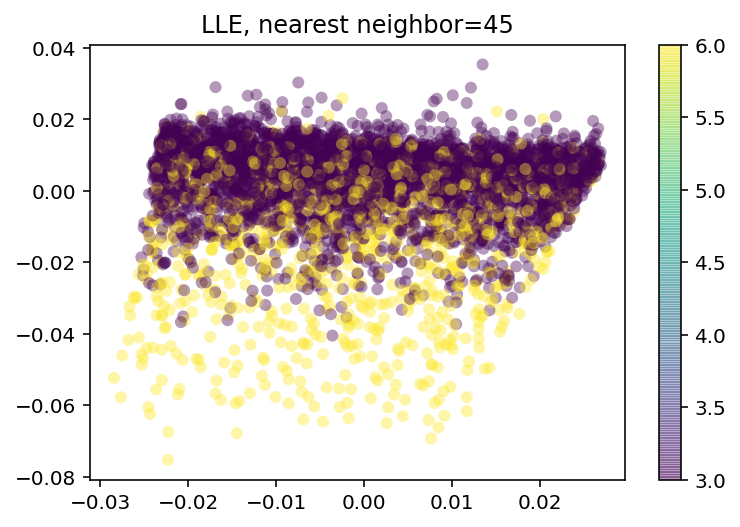

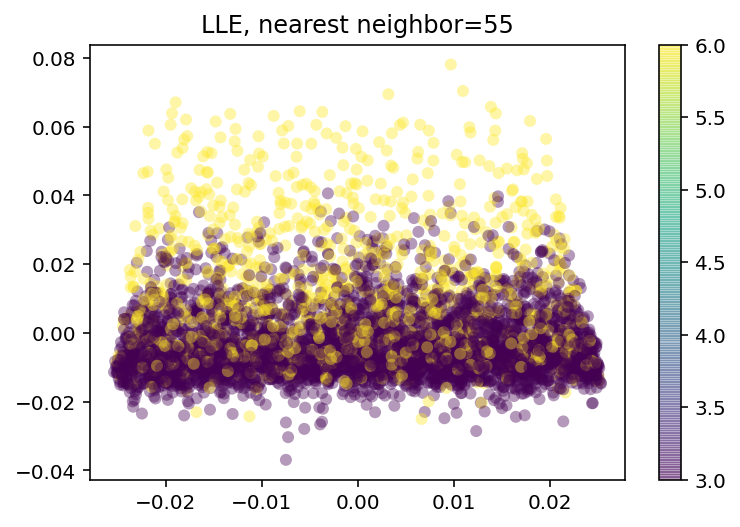

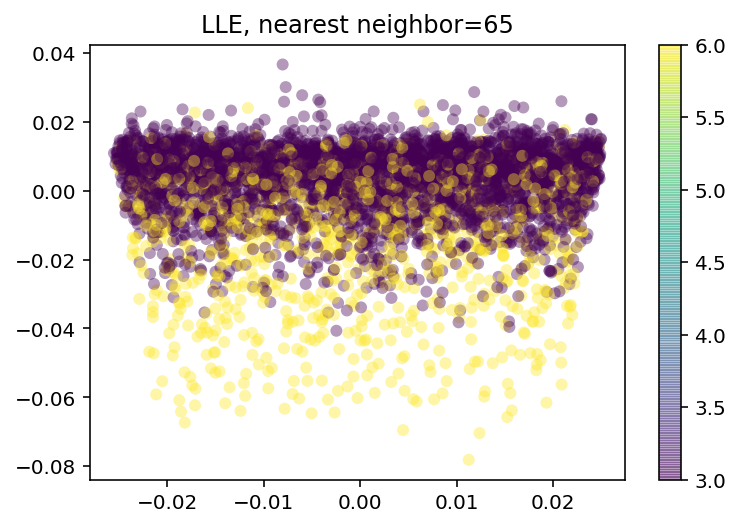

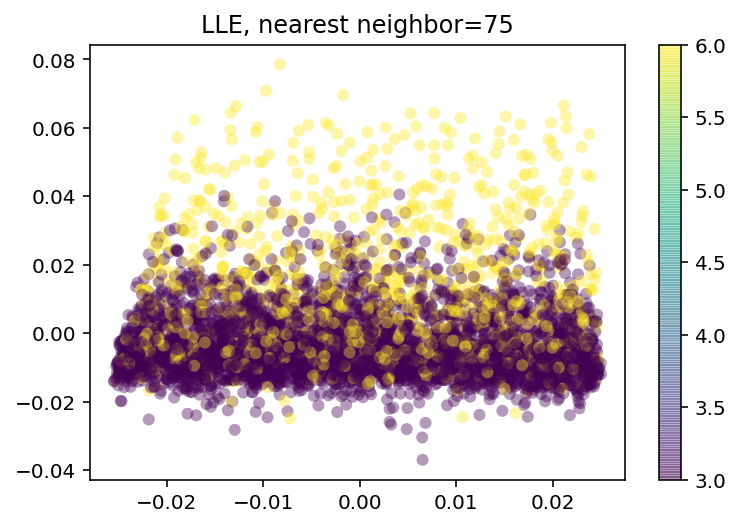

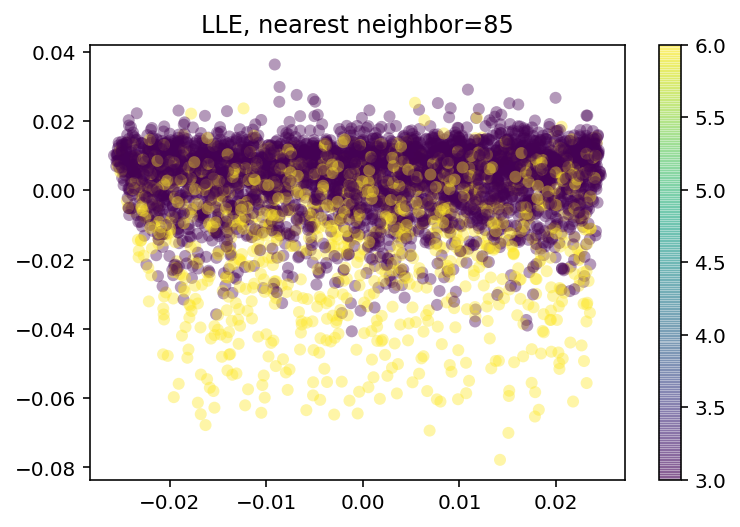

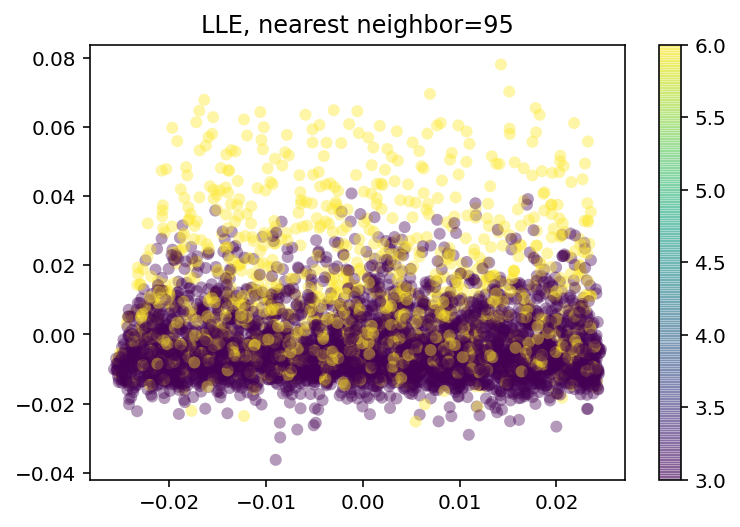

In [13]:
# BS - LLE, import the package

from sklearn.manifold import LocallyLinearEmbedding

# BS - experiment with nearest neighbors between 5 and 100 (ish)
k = np.arange(5, 100, 10)


# BS - loop over each choice of nearest neighbor, fit the LLE, transform
# the data, and plot the result
for i in k:

    n = 2 # Number of dimensions to fit

    lle = LocallyLinearEmbedding(n_neighbors=i, 
                             n_components=n)
    lle.fit(X_rand_reduced)
    proj = lle.transform(X_rand_reduced) 

    plt.scatter(proj[:,0], proj[:,1], 
            c=y_rand, cmap="viridis", edgecolor="None", alpha=0.4)
    plt.title("LLE, nearest neighbor=%i" %i)
    plt.colorbar()
    plt.show()

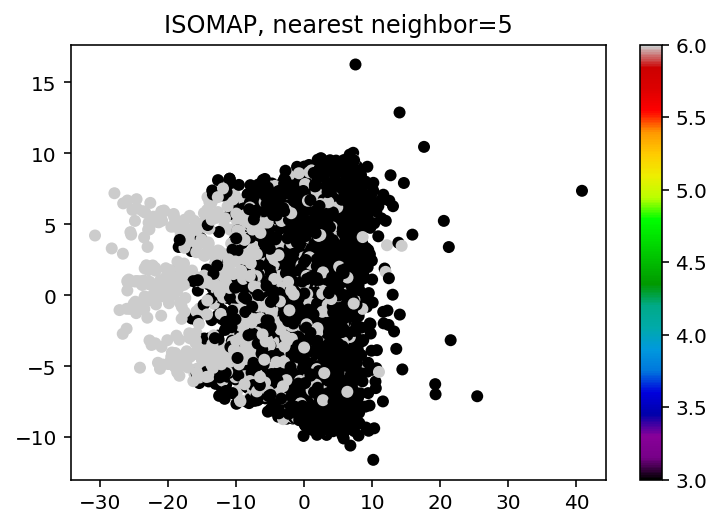

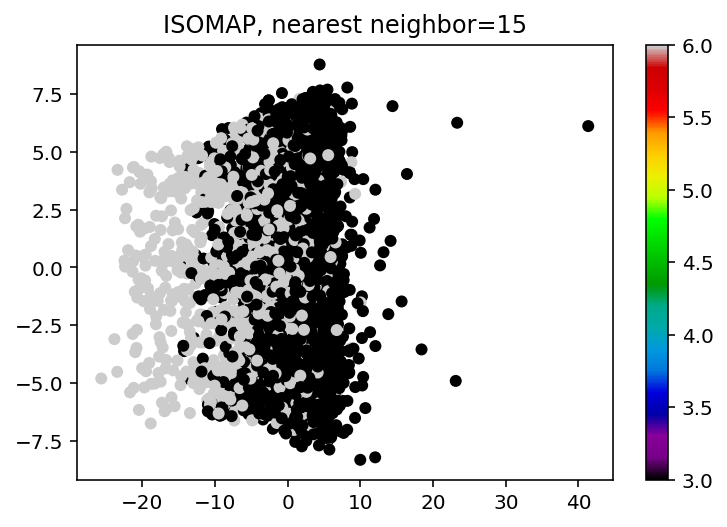

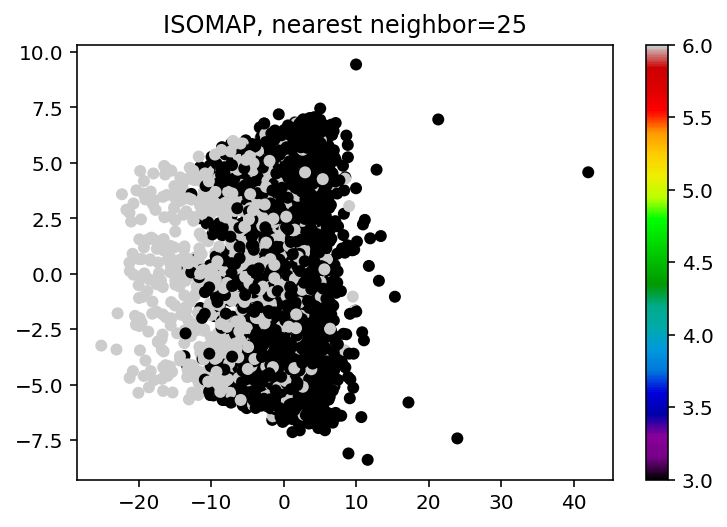

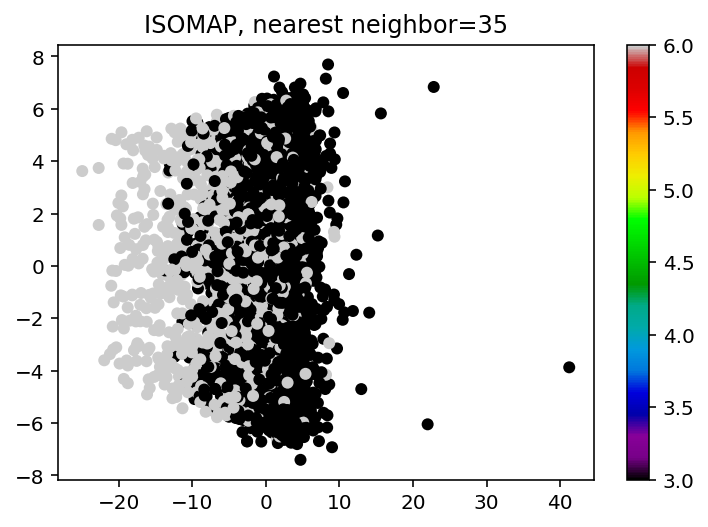

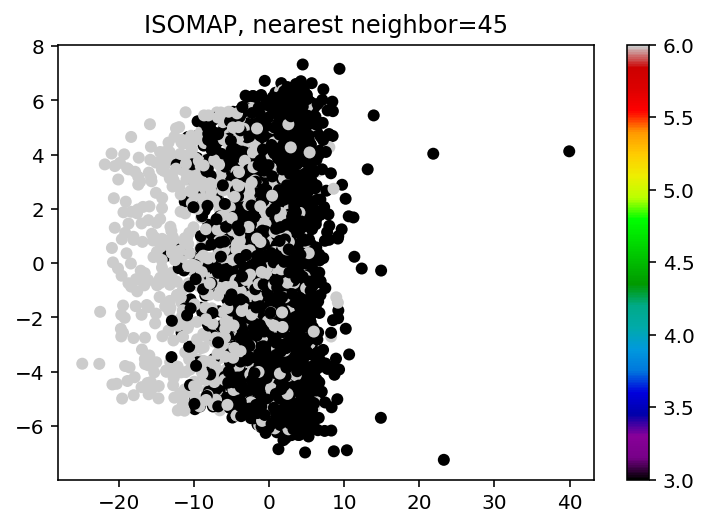

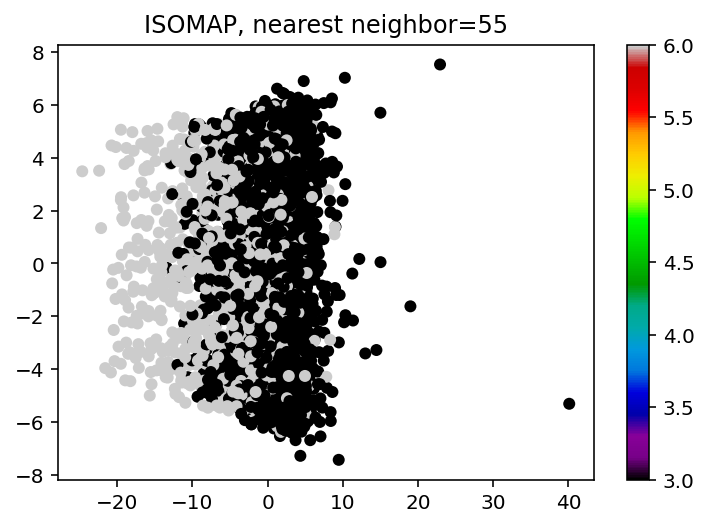

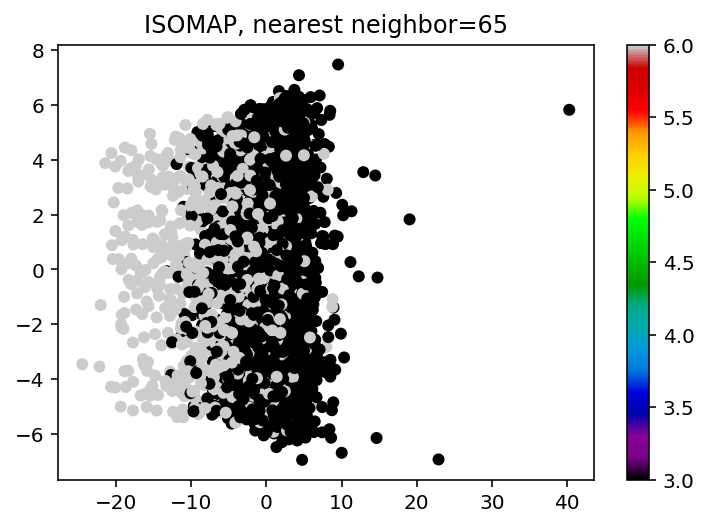

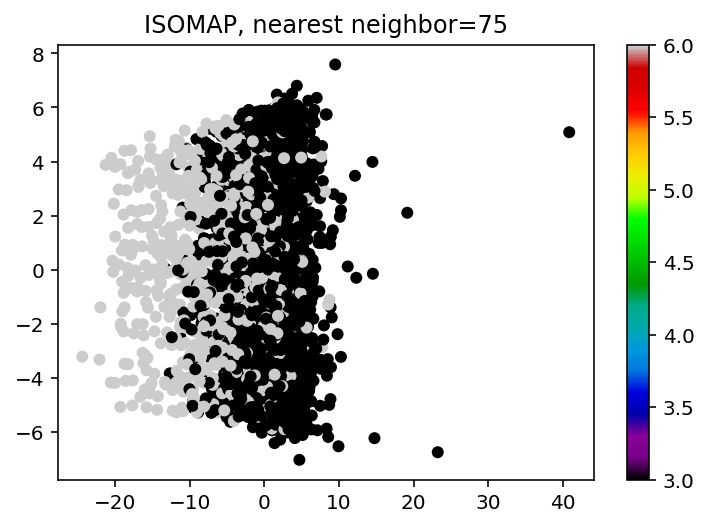

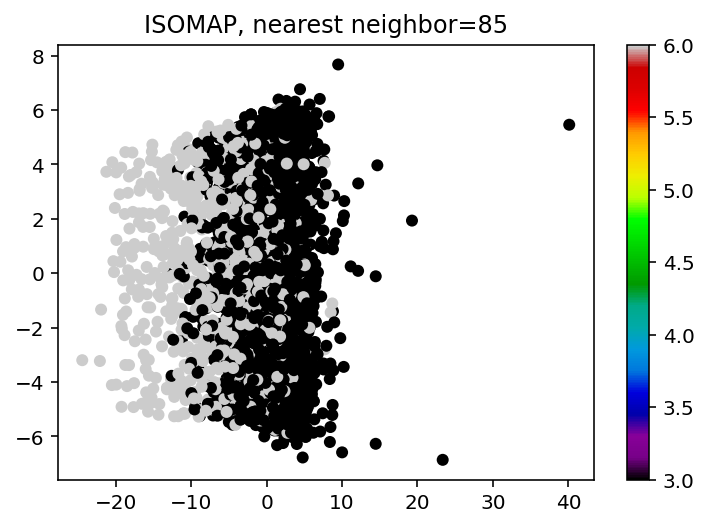

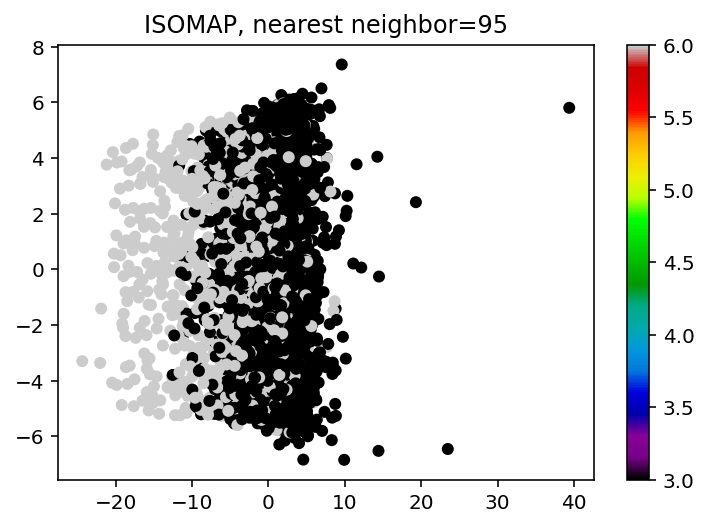

In [14]:
# BS - ISOMAP, import the package

from sklearn.manifold import Isomap

# BS - experiment with nearest neighbor

k = np.arange(5, 100, 10)

# BS - loop over each nearest neighbor choice, fit and 
# transform the data, and plot
for i in k:
    
    n = 2 #number of dimensions to fit
    
    iso = Isomap(n_neighbors=i,
             n_components=2)
    iso.fit(X_rand)

    X_rand_reduced = iso.transform(X_rand)

    plt.title("ISOMAP, nearest neighbor=%i" %i)
    plt.scatter(X_rand_reduced[:,0], X_rand_reduced[:,1], 
            c=y_rand, cmap="nipy_spectral", edgecolor="None")
    plt.colorbar()
    plt.show()
    
# BS - I'm just going to let the colorbar thing go...

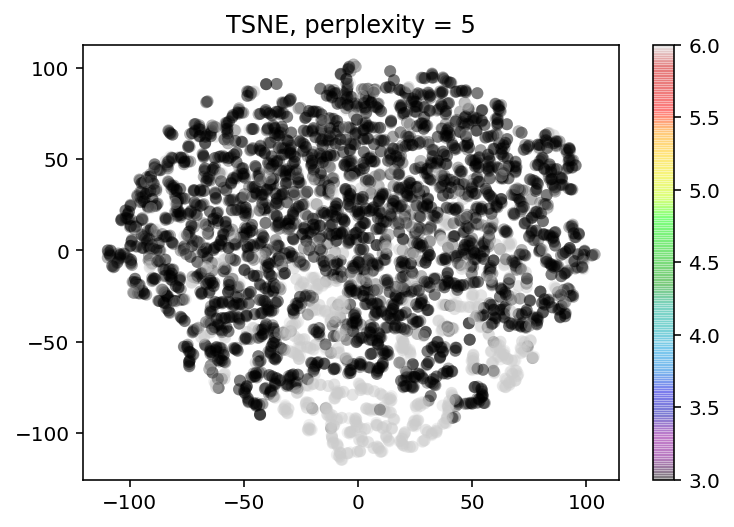

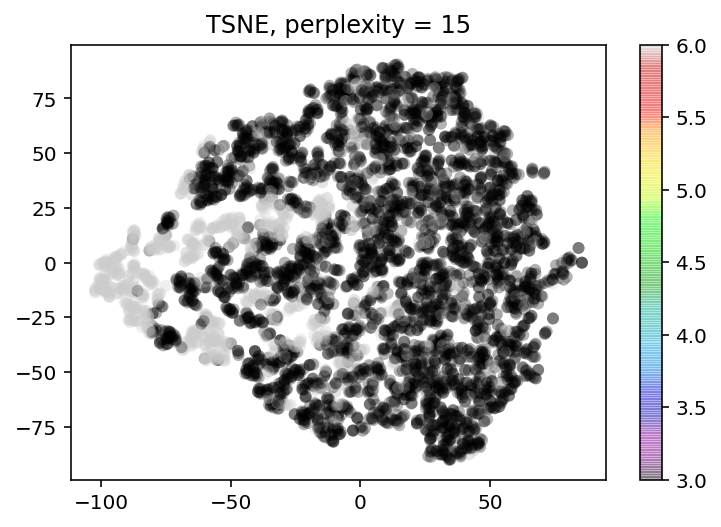

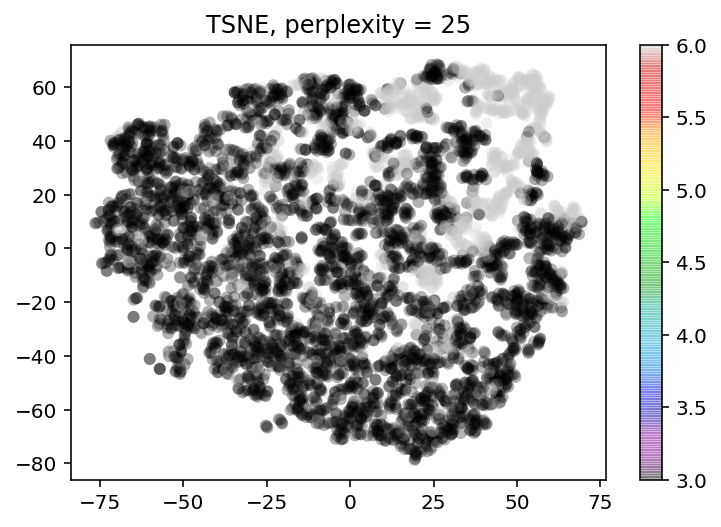

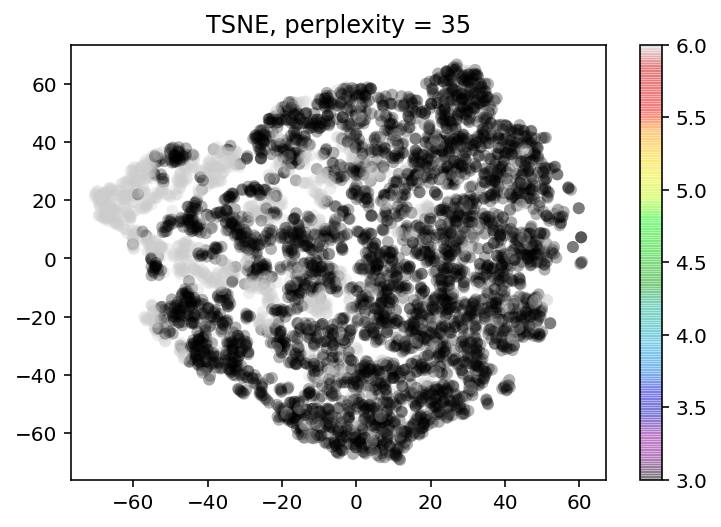

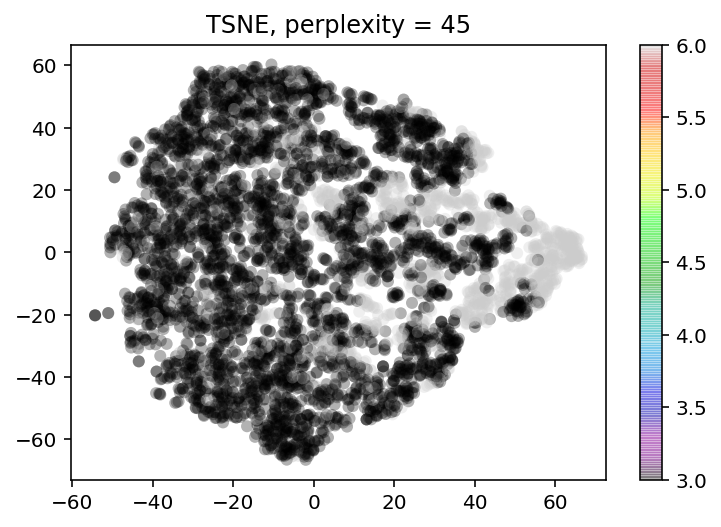

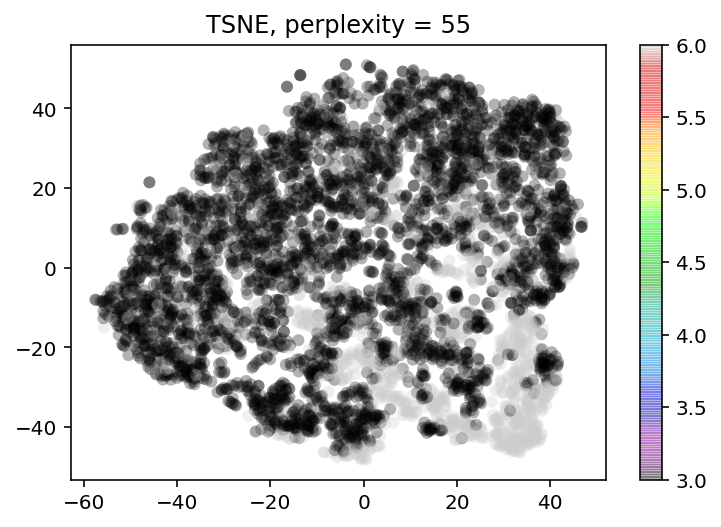

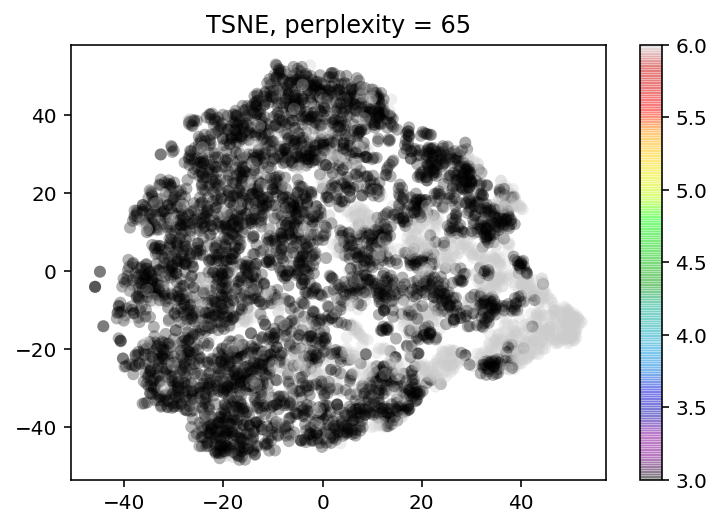

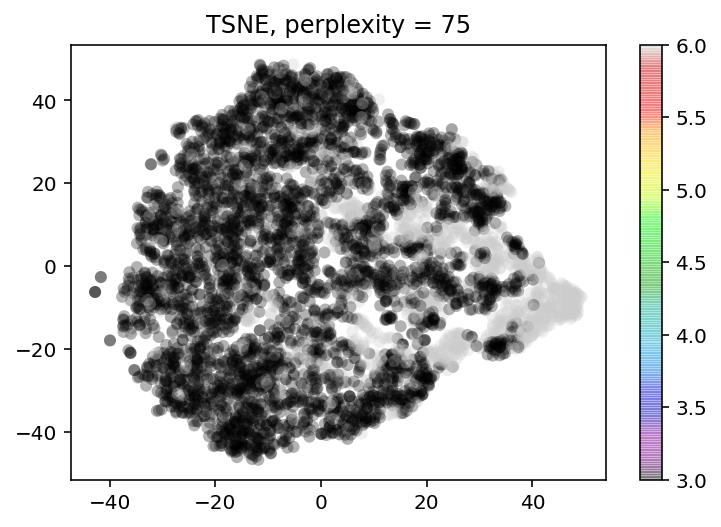

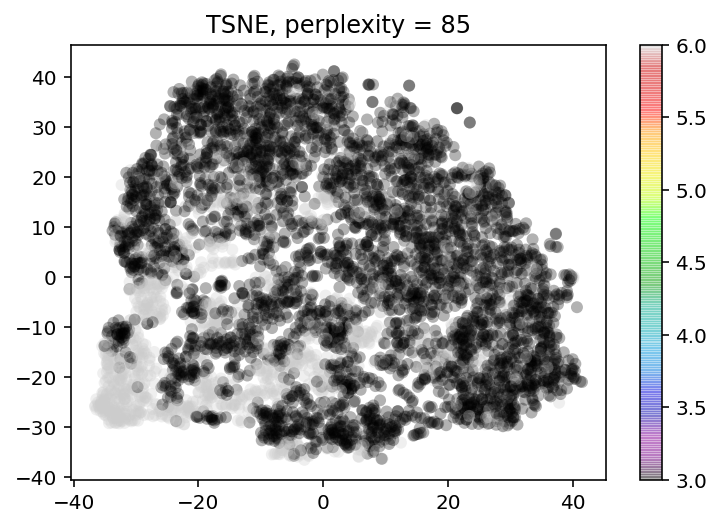

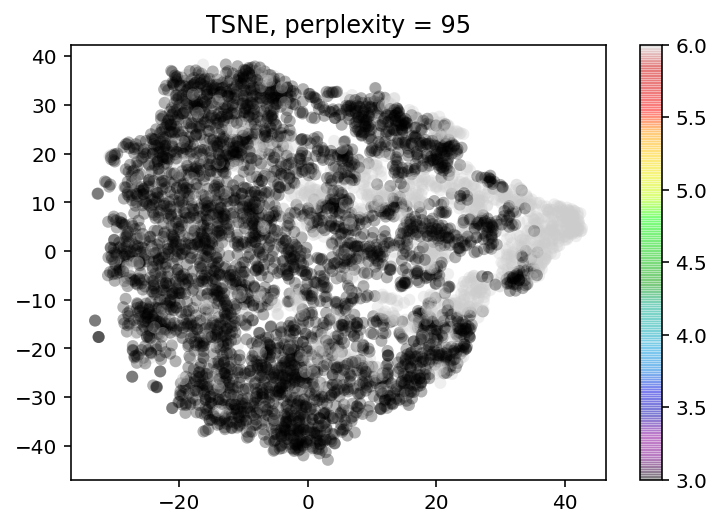

In [15]:
# BS - TSNE, import the package

from sklearn.manifold import TSNE

# BS - experiment with perplexity
k = np.arange(5, 100, 10)

# BS - loop through the perplexity values, fit, transform
# and plot data
for i in k:

    n = 2 # Number of dimensions to fit
    
    tsne = TSNE(n_components=n,learning_rate=200, perplexity=i)

    X_reduced_tsne = tsne.fit_transform(X_rand)
    
    plt.title("TSNE, perplexity = %i" %i)
    plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], 
            c=y_rand, cmap="nipy_spectral", alpha=0.3, 
            edgecolor="None")
    plt.colorbar()
    plt.show()